<a href="https://colab.research.google.com/github/sabrinabenb/Graph-Neural-Network-GNN/blob/main/GCN2_on_TuDataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.3.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 40.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from typing import List, Optional, Tuple, Union

import torch.nn.functional as F
from torch import Tensor

from torch_geometric.nn.aggr import Aggregation, MultiAggregation
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptPairTensor, Size, SparseTensor
from torch_geometric.utils import spmm

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


<IPython.core.display.Javascript object>

In [ ]:
import argparse
import os.path as osp
import time

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,SAGEConv,GATConv
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.logging import init_wandb, log
from torch_geometric.nn import  GCNConv, global_add_pool
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.transforms import OneHotDegree


dataset = TUDataset(root='data/Tudataset', name='NCI1').shuffle()

train_loader = DataLoader(dataset[:0.9], 128, shuffle=True)
test_loader = DataLoader(dataset[0.9:], 128)




if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    # MPS is currently slower than CPU due to missing int64 min/max ops
    device = torch.device('cpu')
else:
    device = torch.device('cpu')

init_wandb(
    name=f'GIN-{dataset}',
    batch_size=128,
    lr=0.01,
    epochs=100,
    hidden_channels=16,
    num_layers=2,
    device=device,
)

from torch_geometric.nn import GCN2Conv


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, alpha, theta,
                 shared_weights=True, dropout=0.0):
        super().__init__()

        torch.manual_seed(1234567)
        self.lins = torch.nn.ModuleList()
        self.lins.append(Linear(dataset.num_features, hidden_channels))
        self.lins.append(Linear(hidden_channels, dataset.num_classes))

        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(
                GCN2Conv(hidden_channels, alpha, theta, layer + 1,
                         shared_weights, normalize=False))

        self.dropout = dropout


    def forward(self, x, edge_index,batch):
        x = F.dropout(x, self.dropout, training=self.training)
        x = x_0 = self.lins[0](x).relu()

        for conv in self.convs:
            x = F.dropout(x, self.dropout, training=self.training)
            x = conv(x, x_0, edge_index)
            x = x.relu()

        x = F.dropout(x, self.dropout, training=self.training)
        x = self.lins[1](x)
        x = global_add_pool(x, batch)
        return x


model = Net(
    in_channels=dataset.num_features,
    hidden_channels=16,
    out_channels=dataset.num_classes,
    num_layers=2,
    alpha=0.1,
    theta=0.5,
    shared_weights=True, dropout=0.6
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)


times = []
for epoch in range(1, 100+ 1):
    start = time.time()
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)
    times.append(time.time() - start)
print(f'Median time per epoch: {torch.tensor(times).median():.4f}s')

Processing...
Done!


Epoch: 001, Loss: 1.0423, Train: 0.5004, Test: 0.5401
Epoch: 002, Loss: 0.6848, Train: 0.5061, Test: 0.5426
Epoch: 003, Loss: 0.6793, Train: 0.5526, Test: 0.5791
Epoch: 004, Loss: 0.6764, Train: 0.5529, Test: 0.5645
Epoch: 005, Loss: 0.6790, Train: 0.5769, Test: 0.5937
Epoch: 006, Loss: 0.6821, Train: 0.5007, Test: 0.5377
Epoch: 007, Loss: 0.6785, Train: 0.4980, Test: 0.5426
Epoch: 008, Loss: 0.6815, Train: 0.4974, Test: 0.5401
Epoch: 009, Loss: 0.6916, Train: 0.5856, Test: 0.5718
Epoch: 010, Loss: 0.6778, Train: 0.5504, Test: 0.5182
Epoch: 011, Loss: 0.6792, Train: 0.5050, Test: 0.5377
Epoch: 012, Loss: 0.6755, Train: 0.5731, Test: 0.5961
Epoch: 013, Loss: 0.6803, Train: 0.5009, Test: 0.5401
Epoch: 014, Loss: 0.6817, Train: 0.5036, Test: 0.5377
Epoch: 015, Loss: 0.6779, Train: 0.5109, Test: 0.5426
Epoch: 016, Loss: 0.6723, Train: 0.5775, Test: 0.5693
Epoch: 017, Loss: 0.6766, Train: 0.5926, Test: 0.6229
Epoch: 018, Loss: 0.6798, Train: 0.5885, Test: 0.5912
Epoch: 019, Loss: 0.6797, Tr

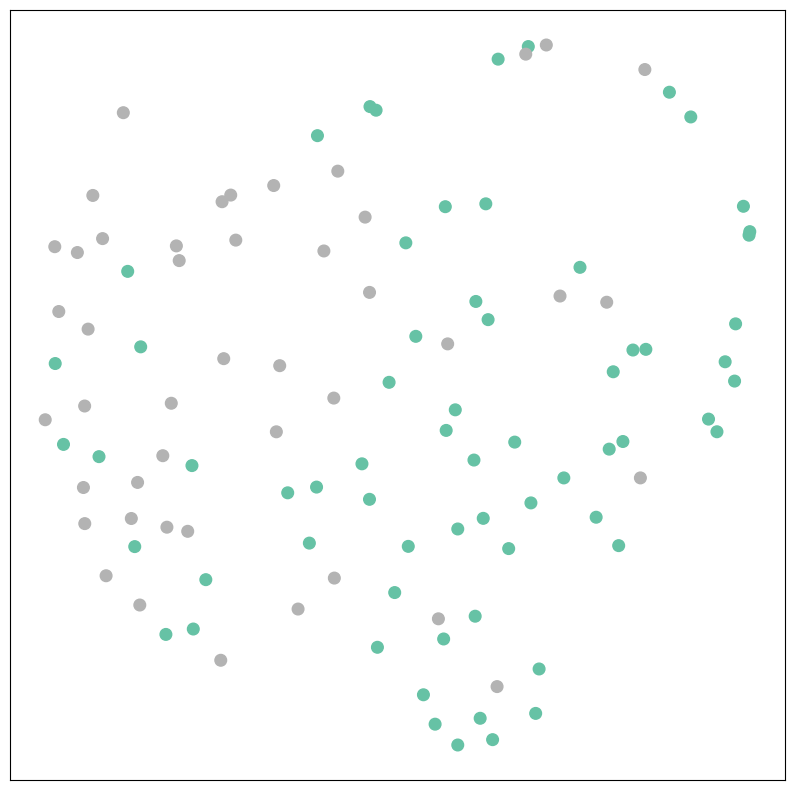

In [ ]:
model.eval()

for data in test_loader:

  out = model(data.x, data.edge_index, data.batch)

  visualize(out, color=data.y)



